In [7]:
import importlib
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import numpy as np

import Dataset
import LinearClassifier

import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard

from IPython.display import SVG, clear_output

from matplotlib import pyplot as plt

mean = [125.307, 122.95, 113.865]
std  = [62.9932, 62.0887, 66.7048]
num_classes = 10

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
img_dims = (32, 32, 3)

for i in range(3):
    x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
    x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]

x_test1d = x_test.reshape([x_test.shape[0], 3072, 1, 1])
x_train1d = x_train.reshape([x_train.shape[0], 3072, 1, 1])

In [2]:
# import keras

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


# importlib.reload(Dataset)  # reload module in case it was modified
# # Load dataset
# dataset = Dataset.load_cifar()

# x_train = dataset['train']['data']
# x_train2d = x_train.reshape([x_train.shape[0], 32, 32, 3])
# y_labels = dataset['train']['labels']
# y_train = np.zeros((50000, 10))
# y_train[range(y_train.shape[0]),y_labels] = 1

# x_test = dataset['test']['data']
# x_test2d = x_test.reshape([x_test.shape[0], 32, 32, 3])
# y_labels = dataset['test']['labels']
# y_test = np.zeros((10000, 10))
# y_test[range(y_test.shape[0]),y_labels] = 1

img_dims = (32, 32, 3)

# Linear Classifier
## Learning Rate
Experimenting with multiple learning rates and showing accuracy on test batch

In [ ]:
importlib.reload(LinearClassifier)  # reload module in case it was modified

lr_stats = pd.DataFrame()
learning_rates = [.1, .03, .01, .003, .001, .0007, .0005, .0003, .0002, .0001]

for learning_rate in learning_rates:
    print('Computing learning_rate %f' % learning_rate)
    model = LinearClassifier.LinearClassifier(10, 3072, 
                          loss_calculator=LinearClassifier.SoftmaxCalculator(),
                          learning_rate=learning_rate)
    stats = {}
    stats['learning_rate'] = learning_rate
    stats['initial_accuracy'] = model.measure_accuracy(dataset)
    model.train(dataset)
    stats['final_accuracy'] = model.measure_accuracy(dataset)
    lr_stats = lr_stats.append(stats, ignore_index=True)
print(lr_stats)

In [ ]:
ax = lr_stats.plot(x='learning_rate', y='final_accuracy',
              title='Accuracy', logx=True)
lr_stats.plot(x='learning_rate', y='initial_accuracy',
              title='Accuracy', logx=True, ax=ax)

plt.xlim(max(learning_rates), min(learning_rates))
plt.show()

## Training Rounds
Experiment doing multiple rounds on the same training data.

Very evident for badly initialized W ($U(0,1)$, for example), less so for properly initialized values ($N(0, sqrt(2/n)$, for example) because accuracy starts high already.

In [ ]:
importlib.reload(LinearClassifier)  # reload module in case it was modified

tr_stats = pd.DataFrame()
learning_rate = 0.0003
model = LinearClassifier.LinearClassifier(10, 3072, 
                      loss_calculator=LinearClassifier.Softmax(),
                      learning_rate=learning_rate)
for i in range(10):
    print('Round', i)
    model.train(dataset)
    tr_stats = tr_stats.append({'round' : i,
                                'accuracy' : model.measure_accuracy(dataset)},
                                ignore_index=True)
print(tr_stats)

In [ ]:
tr_stats.plot(x='round', y='accuracy', title='Accuracy')
plt.show()

## Neural Network

In [ ]:
importlib.reload(LinearClassifier)  # reload module in case it was modified

model = LinearClassifier.NeuralNetwork(10, 3072, [200, 100])
model.train(dataset)
print('accuracy:', model.measure_accuracy(dataset))
# model.train(dataset)
# print('accuracy:', model.measure_accuracy(dataset))

In [ ]:
model.train(dataset)

In [ ]:
model.measure_accuracy(dataset)

## Keras

In [7]:

def show_model(model):
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
#         clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        

### Linear Classifier

In [ ]:
model = Sequential()
model.add(Dense(units=10, activation='softmax', input_dim=3072))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)
print(loss_and_metrics)

### Neural Network

In [ ]:
model = Sequential()
model.add(Dense(units=200, activation='relu', kernel_regularizer=keras.regularizers.l2(.001), input_dim=3072))
model.add(Dense(units=100, activation='relu', kernel_regularizer=keras.regularizers.l2(.001)))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)
print(loss_and_metrics)

### Convolutional Neural Network
#### Naive model
This model converges at 0.66 accuracy

In [9]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=[32, 32, 3]))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu', dilation_rate=2))
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])


# show_model(model)

plot = PlotLearning()
log_tensorboard = TensorBoard(log_dir='./logs', write_graph=True, write_grads=True, write_images=True)

val_acc = [.1]
train_acc = [.1]

In [ ]:
model = keras.models.load_model('models/keras-cifar-cnn.h5')


In [12]:

h = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test))
val_acc += h.history['val_acc']
train_acc += h.history['acc']
print(val_acc)
print(train_acc)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 28s 554us/step - loss: 1.0950 - acc: 0.6201 - val_loss: 8.1187 - val_acc: 0.4668
Epoch 2/20
50000/50000 [==============================] - 28s 554us/step - loss: 1.0741 - acc: 0.6286 - val_loss: 9.9145 - val_acc: 0.3654
Epoch 3/20
50000/50000 [==============================] - 27s 549us/step - loss: 1.0488 - acc: 0.6379 - val_loss: 8.5557 - val_acc: 0.4434
Epoch 4/20
50000/50000 [==============================] - 27s 548us/step - loss: 1.0296 - acc: 0.6455 - val_loss: 7.3057 - val_acc: 0.5183
Epoch 5/20
50000/50000 [==============================] - 27s 544us/step - loss: 1.0080 - acc: 0.6543 - val_loss: 9.7891 - val_acc: 0.3739
Epoch 6/20
50000/50000 [==============================] - 27s 541us/step - loss: 0.9875 - acc: 0.6592 - val_loss: 8.5666 - val_acc: 0.4460
Epoch 7/20
50000/50000 [==============================] - 27s 547us/step - loss: 0.9730 - acc: 0.6656 - val_loss: 6.

In [ ]:
lr = 0.00001

# plot = PlotLearning()
while (lr > 0.000005):
    print('Traning with lr = %.7f' % lr)
    keras.backend.set_value(model.optimizer.lr, lr)
    model.fit(x_train2d, y_train, epochs=2, batch_size=32, validation_data=(x_test2d, y_test))
    lr *= .95

loss_and_metrics = model.evaluate(x_test2d, y_test, batch_size=128)
print(loss_and_metrics)

In [ ]:
# importlib.reload(keras.models)
# importlib.reload(h5py)

model.save('models/keras-cifar-cnn.h5')

#### Fully convolutional model

In [ ]:
img_dims = (32, 32, 3)

conv_parameters = {
    'padding': 'same',
    'activation': 'relu',
    'kernel_initializer': 'he_normal',
    'kernel_regularizer': keras.regularizers.l2(.01)
}

inputs = Input(img_dims)
# Input: 32x32x3

bn0 = BatchNormalization()(inputs)

conv1 = Conv2D(filters=32, kernel_size=3, **conv_parameters)(bn0)
conv1 = Conv2D(filters=32, kernel_size=3, **conv_parameters)(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
# pool1's output is 16x16x32
bn1 = BatchNormalization()(pool1)

conv2 = Conv2D(filters=64, kernel_size=3, **conv_parameters)(bn1)
conv2 = Conv2D(filters=64, kernel_size=3, **conv_parameters)(conv2)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
# pool2's output is 8x8x64
bn2 = BatchNormalization()(pool2)

conv3 = Conv2D(filters=128, kernel_size=3, **conv_parameters)(bn2)
conv3 = Conv2D(filters=128, kernel_size=3, **conv_parameters)(conv3)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
# pool3's output is 4x4x128
bn3 = BatchNormalization()(pool3)

conv4 = Conv2D(filters=256, kernel_size=3, **conv_parameters)(bn3)
conv4 = Conv2D(filters=256, kernel_size=3, **conv_parameters)(conv4)
pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
# pool4's output is 2x2x256

# drop = Dropout(.75)(pool4)
# conv5 = Conv2D(filters=100, kernel_size=2, activation='relu')(drop)
# conv5 = Conv2D(filters=10, kernel_size=1, activation='softmax')(conv5)
# pool4's output is 1x1x10


flatten = Flatten()(pool4)
drop1 = Dropout(0.75)(flatten)

fc1 = Dense(units=512, activation='relu')(drop1)
drop2 = Dropout(0.75)(fc1)
fc2 = Dense(units=256, activation='relu')(drop2)
fc3 = Dense(units=10, activation='softmax')(fc2)

model = Model(inputs=[inputs], outputs=[fc3])

sgd = keras.optimizers.SGD(lr=.01, momentum=0.5, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
val_acc_fc = [.1]
train_acc_fc = [.1]

In [ ]:
h = model.fit(x_train2d, y_train, epochs=20, batch_size=128, validation_data=(x_test2d, y_test))
val_acc_fc += h.history['val_acc']
train_acc_fc += h.history['acc']
print(val_acc_fc)
print(train_acc_fc)


In [ ]:
# keras.backend.set_value(model.layers[-3].rate, .75)
drop1.rate = .99
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
plt.plot(val_acc_fc, label='val_acc')
plt.plot(train_acc_fc, label='train_acc')

plt.legend()
plt.show()

In [ ]:

df['val_acc reg=0.001'] = val_acc
df['train_acc reg=0.001'] = train_acc

df['val_acc reg=0.01'] = val_acc_reg
df['train_acc reg=0.01'] = train_acc_reg

df['val_acc reg=0'] = val_acc_no_reg
df['train_acc reg=0'] = train_acc_no_reg

df['val_acc decay=1e-5'] = val_acc_dec
df['train_acc decay=1e-5'] = train_acc_dec

df['val_small'] = val_acc_small
df['train_small'] = train_acc_small

df.to_csv('models/accuracy_df.csv')

ax = df.plot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# Hardcoded decay
lr = keras.backend.get_value(model.optimizer.lr)
target_lr = lr / 10
while lr > target_lr:
    print('Training with lr = %.7f' % lr)
    keras.backend.set_value(model.optimizer.lr, lr)
    model.fit(x_train2d, y_train, epochs=5, batch_size=32, validation_data=(x_test2d, y_test))
    lr *= .90

### DenseNet

In [5]:
conv_parameters = {
    'padding': 'same',
    'activation': 'relu',
    'kernel_initializer': 'he_normal',
    'kernel_regularizer': keras.regularizers.l2(.0001)
}

inputs = Input(img_dims)

concat = inputs
x = Conv2D(filters=32, kernel_size=3, **conv_parameters)(concat)
concat = concatenate([x, concat])

x = Conv2D(filters=32, kernel_size=3, **conv_parameters)(concat)
concat = concatenate([x, concat])

x = Conv2D(filters=32, kernel_size=3, **conv_parameters)(concat)
concat = concatenate([x, concat])

x = Conv2D(filters=32, kernel_size=3, **conv_parameters)(concat)
concat = concatenate([x, concat])

x = Conv2D(filters=32, kernel_size=3, **conv_parameters)(concat)
concat = concatenate([x, concat])

x = Conv2D(filters=32, kernel_size=3, **conv_parameters)(concat)
concat = concatenate([x, concat])

x = Conv2D(filters=32, kernel_size=3, **conv_parameters)(concat)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=[x])

sgd = keras.optimizers.SGD(lr=.01, momentum=0.5, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
print(model.count_params())

val_acc = [.1]
train_acc = [.1]

3477718


In [9]:
growth_rate = 12
layers_per_block = 12
conv_parameters = {
    'padding': 'same',
    'activation': 'relu',
    'kernel_initializer': 'he_normal',
    'kernel_regularizer': keras.regularizers.l2(.0001)
}

def composite_layer(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=growth_rate * 4, kernel_size=1, **conv_parameters)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=growth_rate, kernel_size=3, **conv_parameters)(x)
    return x
    
def dense_block(x):
    concat = x
    for _ in range(layers_per_block):
        x = composite_layer(x)
        concat = concatenate([x, concat])
    return x
    
def transition_layer(x):
    nchannels = int(x.get_shape()[-1])
    x = BatchNormalization()(x)
    x = Conv2D(filters=nchannels // 2, kernel_size=1, **conv_parameters)(x)
    x = AveragePooling2D(pool_size=(2,2))(x)
    return x

inputs = Input(img_dims)

x = dense_block(inputs)
x = transition_layer(x)

x = dense_block(x)
x = transition_layer(x)

x = dense_block(x)
x = transition_layer(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=[x])

sgd = keras.optimizers.SGD(lr=.01, momentum=0.5, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
print(model.count_params())

val_acc = [.1]
train_acc = [.1]

217516


In [11]:
h = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))
val_acc_fc += h.history['val_acc']
train_acc_fc += h.history['acc']
print(val_acc_fc)
print(train_acc_fc)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 352s 7ms/step - loss: 53115764.9587 - acc: 0.0990 - val_loss: 52784285.1840 - val_acc: 0.0991
Epoch 2/10
50000/50000 [==============================] - 363s 7ms/step - loss: 52456043.4125 - acc: 0.0985 - val_loss: 52128495.0016 - val_acc: 0.1000
Epoch 3/10
50000/50000 [==============================] - 361s 7ms/step - loss: 51804300.0038 - acc: 0.0987 - val_loss: 51480860.6208 - val_acc: 0.1002
Epoch 4/10
50000/50000 [==============================] - 358s 7ms/step - loss: 51160631.4637 - acc: 0.0996 - val_loss: 50841071.1680 - val_acc: 0.1000
Epoch 5/10
50000/50000 [==============================] - 360s 7ms/step - loss: 50524685.5232 - acc: 0.0997 - val_loss: 50209076.4992 - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 364s 7ms/step - loss: 49896927.0656 - acc: 0.1022 - val_loss: 49585500.0256 - val_acc: 0.1000
Epoch 7/10
50000/50000 [==============

NameError: name 'val_acc_fc' is not defined

In [8]:
from DenseNet import densenet, scheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint


img_input = Input(shape=img_dims)
output    = densenet(img_input,num_classes)
model     = Model(img_input, output)

sgd = keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set callback
tb_cb     = TensorBoard(log_dir='./densenet/', histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
ckpt      = ModelCheckpoint('./ckpt.h5', save_best_only=False, mode='auto', period=10)
cbks      = [change_lr,tb_cb,ckpt]

# set data augmentation
print('Using real-time data augmentation.')
datagen   = ImageDataGenerator(horizontal_flip=True,width_shift_range=0.125,height_shift_range=0.125,
                               fill_mode='constant',cval=0.)

datagen.fit(x_train)


Using real-time data augmentation.


In [3]:
print(model.count_params())

850606


In [18]:

batch_size         = 40         # 64 or 32 or other
epochs             = 5
iterations         = 782
# start training
h = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size), steps_per_epoch=iterations, 
                    epochs=epochs, callbacks=cbks,validation_data=(x_test, y_test))

val_acc += h.history['val_acc']
train_acc += h.history['acc']

model.save('densenet.h5')

Epoch 1/5
782/782 [==============================] - 496s 635ms/step - loss: 0.7397 - acc: 0.8700 - val_loss: 0.8474 - val_acc: 0.8352
Epoch 2/5
782/782 [==============================] - 491s 627ms/step - loss: 0.7115 - acc: 0.8691 - val_loss: 0.8367 - val_acc: 0.8277
Epoch 3/5
782/782 [==============================] - 474s 607ms/step - loss: 0.7005 - acc: 0.8690 - val_loss: 0.7965 - val_acc: 0.8397
Epoch 4/5
782/782 [==============================] - 475s 607ms/step - loss: 0.6852 - acc: 0.8726 - val_loss: 0.7806 - val_acc: 0.8398
Epoch 5/5
782/782 [==============================] - 475s 607ms/step - loss: 0.6885 - acc: 0.8714 - val_loss: 0.9960 - val_acc: 0.7947


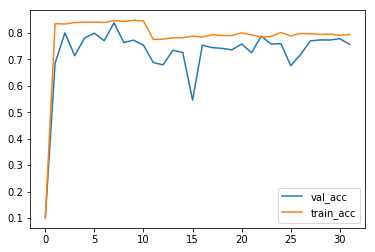

In [16]:
plt.plot(val_acc, label='val_acc')
plt.plot(train_acc, label='train_acc')

plt.legend()
plt.show()

## TensorFlow
### Linear classifier

In [ ]:
import tensorflow as tf

X = tf.placeholder(tf.float32, shape=[None, 3072],name='input')
W = tf.Variable(tf.zeros([3072, 10]), name='weights')
b = tf.Variable(tf.zeros([10]), name='biases')

Y = tf.nn.softmax(tf.matmul(X, W) + b, name='model')
Y_ = tf.placeholder(tf.float32, shape=[None, 10], name='expected_labels')

# loss function
cross_entropy = -tf.reduce_sum(Y_ * tf.log(Y))

# % of correct answers found in batch
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.001
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100000, 0.96, staircase=True)

optimizer = tf.train.GradientDescentOptimizer(0.003)
train_step = optimizer.minimize(cross_entropy, global_step=global_step)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

batch_size = 100
test_data = {X: x_test, Y_: y_test}

for i in range(1000):
    # load batch of images and correct answers
    idx = np.random.randint(x_train.shape[0], size=batch_size)
    batch_x = x_train[idx]
    batch_y = y_train[idx]
    train_data={X: batch_x, Y_: batch_y}

    # train
    sess.run(train_step, feed_dict=train_data)
    
    a,c = sess.run([accuracy, cross_entropy], feed_dict=test_data)
    print(a, c)

In [ ]:
# success ?
test_data = {X: x_test, Y_: y_test}
a,c = sess.run([accuracy, cross_entropy], feed_dict=test_data)
print(a, c)